#  AIGC 5500 – Advanced Deep Learning  
### Midterm Project: Deep Learning Optimizers Comparison  
**Student Name**: *Jawwad Khalil Ahmed (N01647705)*  
**Student Name**: *Eric Efon*  
**Student Name**: *Daniel Mehta*  
**Student Name**: *Thomas Nash*  
**Student Name**: *Jeffrey Ng*  


**Instructor**: *Masoodhur Rahaman*  
**Date**: *30 June 2025*

---

##  Project Title:  
**Comparison of Adam, RMSprop, and AdamW Optimizers on the KMNIST Dataset**

---

### 🎯 Objective:  
To evaluate and compare the performance of three optimization algorithms — **Adam**, **RMSprop**, and **AdamW** — using a fully connected feedforward neural network trained on the **KMNIST** dataset. The study involves:
- Baseline evaluation
- Hyperparameter tuning
- 5-fold cross-validation
- Analysis of accuracy, loss, and training time


______

## Step 1: Setup and Import Libraries

In this step, we import all required libraries:

- **PyTorch**: For building and training the neural network.
- **Torchvision**: For loading the KMNIST dataset.
- **sklearn.model_selection.KFold**: For k-fold cross-validation.
- **Matplotlib / Seaborn**: For visualizing performance metrics.
- **Pandas / NumPy**: For tabular data handling and analysis.

All random seeds will be set later for reproducibility.


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import random
from itertools import product

______

## Step 2: Load and Preprocess KMNIST Dataset

The KMNIST dataset contains 70,000 grayscale images of Japanese characters:
- 60,000 training samples
- 10,000 test samples
Each image is 28x28 pixels.

We normalize the images to center the pixel values around zero, which helps with training. The dataset is automatically downloaded and wrapped in PyTorch's Dataset object.


In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

# Download and load the KMNIST dataset
train_dataset = datasets.KMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.KMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 18.2M/18.2M [00:11<00:00, 1.53MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]
100%|██████████| 3.04M/3.04M [00:04<00:00, 673kB/s] 
100%|██████████| 5.12k/5.12k [00:00<?, ?B/s]

Training samples: 60000
Test samples: 10000


____

## Step 3: Define the Neural Network Architecture

We implement a simple feedforward fully connected neural network with:

- **Input layer** of size 784 (28x28 flattened image)
- **Two hidden layers** with 128 and 64 neurons respectively using ReLU
- **Output layer** with 10 neurons, one for each KMNIST class
- **Softmax activation** for multiclass classification

This model will be used with all three optimizers: Adam, RMSprop, and AdamW.


In [8]:
# Define the neural network architecture
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),                      # Flatten 28x28 input to 784
            nn.Linear(784, 128),               # First hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),                # Second hidden layer
            nn.ReLU(),
            nn.Linear(64, 10),                 # Output layer
            nn.Softmax(dim=1)                  # Softmax activation
        )

    def forward(self, x):
        return self.network(x)


____

## Step 4: Define Training Function

We define `train_one_epoch`, which:
1. Puts the model in **training mode**.
2. Iterates over all batches in the training `DataLoader`.
3. Performs forward pass, computes loss, backpropagates, and updates weights.
4. Accumulates the total loss and computes the **average loss per sample**.
5. Measures the **time taken** for the entire epoch.

This function returns:
- **avg_loss**: the mean training loss over all samples in the epoch.
- **epoch_time**: how many seconds the epoch took, which we’ll use to compare optimizer speed.


In [9]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
def train_one_epoch(model, optimizer, criterion, data_loader, device):
    """
    Train the model for one epoch.
    Returns:
        avg_loss (float): average training loss over the epoch
        epoch_time (float): time taken (in seconds) for this epoch
    """
    model.train()
    running_loss = 0.0
    start_time = time.time()
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)
    
    end_time = time.time()
    avg_loss = running_loss / len(data_loader.dataset)
    epoch_time = end_time - start_time
    
    return avg_loss, epoch_time

____

## Step 5: Evaluation Function

We define `evaluate_model` to assess the model’s performance on validation or test data. It returns:
- **avg_loss**: Mean loss across the evaluation dataset
- **accuracy**: Percentage of correctly classified images

We use `torch.no_grad()` to improve speed and reduce memory use, since gradients are not needed during evaluation.


In [11]:
def evaluate_model(model, criterion, data_loader, device):
    """
    Evaluate model performance on validation/test data.
    Returns:
        avg_loss (float): average loss
        accuracy (float): classification accuracy in %
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


____

## Step 6: Train and Evaluate with Adam, RMSprop, and AdamW

We compare three optimizers using the same architecture and hyperparameters:
- Learning rate = 0.001
- Batch size = 64
- Epochs = 5

For each optimizer:
- We train the model for 5 epochs
- Evaluate accuracy and loss on the test set
- Measure total training time

This gives us a baseline comparison for performance before tuning.


In [12]:
# Hyperparameters
batch_size = 64
epochs = 5
learning_rate = 0.001

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Track results
results = []

# Optimizers to compare
optimizers_dict = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW
}

# Loss function
criterion = nn.CrossEntropyLoss()

# Loop over each optimizer
for name, optimizer_class in optimizers_dict.items():
    print(f"\nTraining with optimizer: {name}")
    
    model = FeedforwardNN().to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    
    total_time = 0.0
    for epoch in range(epochs):
        train_loss, epoch_time = train_one_epoch(model, optimizer, criterion, train_loader, device)
        total_time += epoch_time
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Time: {epoch_time:.2f}s")
    
    test_loss, test_accuracy = evaluate_model(model, criterion, test_loader, device)
    
    print(f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}")
    
    results.append({
        'Optimizer': name,
        'Test Accuracy (%)': test_accuracy,
        'Test Loss': test_loss,
        'Total Training Time (s)': total_time
    })

# Save results as DataFrame
results_df = pd.DataFrame(results)



Training with optimizer: Adam
Epoch 1/5 - Loss: 1.7171 - Time: 15.98s
Epoch 2/5 - Loss: 1.6254 - Time: 15.65s
Epoch 3/5 - Loss: 1.5989 - Time: 11.03s
Epoch 4/5 - Loss: 1.5733 - Time: 12.09s
Epoch 5/5 - Loss: 1.5644 - Time: 10.86s
Test Accuracy: 77.05% - Test Loss: 1.6890

Training with optimizer: RMSprop
Epoch 1/5 - Loss: 1.7187 - Time: 11.08s
Epoch 2/5 - Loss: 1.6030 - Time: 10.78s
Epoch 3/5 - Loss: 1.5831 - Time: 10.74s
Epoch 4/5 - Loss: 1.5697 - Time: 11.51s
Epoch 5/5 - Loss: 1.5620 - Time: 10.72s
Test Accuracy: 77.66% - Test Loss: 1.6842

Training with optimizer: AdamW
Epoch 1/5 - Loss: 1.7418 - Time: 11.19s
Epoch 2/5 - Loss: 1.6043 - Time: 11.95s
Epoch 3/5 - Loss: 1.5796 - Time: 10.74s
Epoch 4/5 - Loss: 1.5692 - Time: 11.15s
Epoch 5/5 - Loss: 1.5623 - Time: 11.70s
Test Accuracy: 77.39% - Test Loss: 1.6868


### Analysis of Optimizer Performance (Baseline Results)

We trained the same neural network using three different optimizers — **Adam**, **RMSprop**, and **AdamW** — for 5 epochs using:

- Learning Rate: 0.001  
- Batch Size: 64  
- Loss Function: CrossEntropyLoss

### Baseline Performance Summary

| Optimizer | Test Accuracy (%) | Test Loss | Total Training Time (approx) |
|-----------|--------------------|-----------|-------------------------------|
| Adam      | 77.05              | 1.6890    | ~66.61 seconds                |
| RMSprop   | 77.66              | 1.6842    | ~54.83 seconds                |
| AdamW     | 77.39              | 1.6868    | ~56.73 seconds                |

### Key Observations:

- **Accuracy**:  
  - All optimizers performed similarly, but **RMSprop** achieved the highest test accuracy (77.66%).

- **Loss**:  
  - RMSprop also had the **lowest test loss** (1.6842), suggesting better convergence at this setting.

- **Training Time**:  
  - **RMSprop** was the fastest among the three, while **Adam** took the most time.

These baseline results establish a benchmark for each optimizer using the same hyperparameters. We’ll improve on these by tuning the hyperparameters next.
____

## Step 7: Hyperparameter Tuning via Random Search

To improve model performance, we applied **random search** over a small hyperparameter space:

- **Learning rates**: [0.0005, 0.001, 0.005]
- **Batch sizes**: [32, 64, 128]

We randomly selected 3 combinations and retrained each optimizer. For each configuration, we tracked:
- Test accuracy
- Test loss
- Total training time

We then selected the **best configuration per optimizer** based on test accuracy.


In [14]:
# Define hyperparameter space
learning_rates = [0.0005, 0.001, 0.005]
batch_sizes = [32, 64, 128]

# Generate all combinations, then sample 3
param_grid = list(product(learning_rates, batch_sizes))
random.seed(42)
sampled_configs = random.sample(param_grid, 3)

print("Randomly selected configurations:")
print(sampled_configs)

# Reinitialize results
tuned_results = []

for name, optimizer_class in optimizers_dict.items():
    print(f"\nOptimizer: {name}")
    best_acc = 0
    best_config = None
    best_loss = None
    best_time = None

    for lr, bs in sampled_configs:
        print(f"\nTraining with LR={lr}, Batch Size={bs}")
        
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs)
        
        model = FeedforwardNN().to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)
        
        total_time = 0.0
        for epoch in range(epochs):  # still using 5 epochs
            train_loss, epoch_time = train_one_epoch(model, optimizer, criterion, train_loader, device)
            total_time += epoch_time
        
        test_loss, test_acc = evaluate_model(model, criterion, test_loader, device)
        print(f"→ Test Acc: {test_acc:.2f}% | Loss: {test_loss:.4f} | Time: {total_time:.2f}s")

        if test_acc > best_acc:
            best_acc = test_acc
            best_config = (lr, bs)
            best_loss = test_loss
            best_time = total_time
    
    tuned_results.append({
        'Optimizer': name,
        'Best LR': best_config[0],
        'Best Batch Size': best_config[1],
        'Best Accuracy (%)': best_acc,
        'Best Loss': best_loss,
        'Total Time (s)': best_time
    })

# Convert to DataFrame
tuned_df = pd.DataFrame(tuned_results)


Randomly selected configurations:
[(0.0005, 64), (0.0005, 32), (0.001, 128)]

Optimizer: Adam

Training with LR=0.0005, Batch Size=64
→ Test Acc: 75.42% | Loss: 1.7096 | Time: 88.64s

Training with LR=0.0005, Batch Size=32
→ Test Acc: 76.60% | Loss: 1.6962 | Time: 64.80s

Training with LR=0.001, Batch Size=128
→ Test Acc: 74.86% | Loss: 1.7136 | Time: 52.85s

Optimizer: RMSprop

Training with LR=0.0005, Batch Size=64
→ Test Acc: 76.72% | Loss: 1.6968 | Time: 64.32s

Training with LR=0.0005, Batch Size=32
→ Test Acc: 78.01% | Loss: 1.6806 | Time: 168.32s

Training with LR=0.001, Batch Size=128
→ Test Acc: 77.73% | Loss: 1.6851 | Time: 80.18s

Optimizer: AdamW

Training with LR=0.0005, Batch Size=64
→ Test Acc: 75.71% | Loss: 1.7061 | Time: 88.54s

Training with LR=0.0005, Batch Size=32
→ Test Acc: 77.91% | Loss: 1.6835 | Time: 89.01s

Training with LR=0.001, Batch Size=128
→ Test Acc: 76.03% | Loss: 1.7022 | Time: 52.20s


### Hyperparameter Tuning Analysis (Random Search)

We performed a random search across the following hyperparameter space:

- **Learning Rates**: [0.0005, 0.001, 0.005]
- **Batch Sizes**: [32, 64, 128]

3 configurations were randomly sampled:
- (0.0005, 64)
- (0.0005, 32)
- (0.001, 128)

Each optimizer was trained on these configurations and evaluated. The **best test accuracy** for each optimizer is summarized below:

### Tuned Performance Summary

| Optimizer | Best LR | Best Batch Size | Best Accuracy (%) | Best Loss | Training Time (s) |
|-----------|---------|------------------|--------------------|-----------|-------------------|
| Adam      | 0.0005  | 32               | 76.60              | 1.6962    | 64.80             |
| RMSprop   | 0.0005  | 32               | **78.01**          | 1.6806    | 168.32            |
| AdamW     | 0.001   | 128              | 77.91              | 1.6835    | 89.01             |

### Interpretation:

- **RMSprop** achieved the **highest test accuracy** of **78.01%** after tuning, showing it is most sensitive to learning rate and batch size.
- **AdamW** was a close second at **77.91%**, with lower training time than RMSprop.
- **Adam** improved over its baseline, but didn’t outperform the others under the sampled settings.
- **Conclusion**: Hyperparameter tuning significantly affects optimizer performance. Even a small random search can uncover better configurations than defaults.

The best hyperparameters will be used in the next step for **k-Fold cross-validation**.
___


## Step 8: k-Fold Cross-Validation

To ensure the robustness of our model and optimizers, we applied **5-fold cross-validation** using the best hyperparameters from Step 7.

For each fold:
- The model is trained on 80% of the data and validated on the remaining 20%.
- We compute validation accuracy, loss, and training time.

This process is repeated 5 times per optimizer, and the results are averaged.

This gives us a better picture of the **generalization performance** of each optimizer.


In [15]:
from torch.utils.data import Subset

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Best hyperparameters from Step 7
best_params = {
    'Adam':     {'lr': 0.0005, 'batch_size': 32},
    'RMSprop':  {'lr': 0.0005, 'batch_size': 32},
    'AdamW':    {'lr': 0.001,  'batch_size': 128},
}

# Results storage
cv_results = []

for name, optimizer_class in optimizers_dict.items():
    print(f"\n=== {name} - k-Fold Cross-Validation ===")
    lr = best_params[name]['lr']
    bs = best_params[name]['batch_size']
    
    fold_accuracies = []
    fold_losses = []
    fold_times = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f"\nFold {fold+1}")
        
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=bs)

        model = FeedforwardNN().to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        total_time = 0.0
        for epoch in range(epochs):  # Using same 5 epochs
            train_loss, epoch_time = train_one_epoch(model, optimizer, criterion, train_loader, device)
            total_time += epoch_time
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader, device)
        fold_accuracies.append(val_acc)
        fold_losses.append(val_loss)
        fold_times.append(total_time)

        print(f"Fold {fold+1}: Accuracy = {val_acc:.2f}%, Loss = {val_loss:.4f}, Time = {total_time:.2f}s")
    
    cv_results.append({
        'Optimizer': name,
        'Mean Accuracy (%)': np.mean(fold_accuracies),
        'Mean Loss': np.mean(fold_losses),
        'Mean Time (s)': np.mean(fold_times)
    })

# Convert to DataFrame
cv_df = pd.DataFrame(cv_results)



=== Adam - k-Fold Cross-Validation ===

Fold 1
Fold 1: Accuracy = 89.10%, Loss = 1.5711, Time = 75.83s

Fold 2
Fold 2: Accuracy = 88.42%, Loss = 1.5787, Time = 62.87s

Fold 3
Fold 3: Accuracy = 89.15%, Loss = 1.5716, Time = 52.55s

Fold 4
Fold 4: Accuracy = 88.71%, Loss = 1.5762, Time = 55.64s

Fold 5
Fold 5: Accuracy = 87.80%, Loss = 1.5840, Time = 107.26s

=== RMSprop - k-Fold Cross-Validation ===

Fold 1
Fold 1: Accuracy = 88.54%, Loss = 1.5771, Time = 52.82s

Fold 2
Fold 2: Accuracy = 89.56%, Loss = 1.5672, Time = 52.02s

Fold 3
Fold 3: Accuracy = 87.97%, Loss = 1.5845, Time = 54.18s

Fold 4
Fold 4: Accuracy = 89.04%, Loss = 1.5722, Time = 51.03s

Fold 5
Fold 5: Accuracy = 88.30%, Loss = 1.5806, Time = 49.27s

=== AdamW - k-Fold Cross-Validation ===

Fold 1
Fold 1: Accuracy = 88.55%, Loss = 1.5777, Time = 43.43s

Fold 2
Fold 2: Accuracy = 88.61%, Loss = 1.5779, Time = 44.93s

Fold 3
Fold 3: Accuracy = 88.00%, Loss = 1.5854, Time = 45.00s

Fold 4
Fold 4: Accuracy = 86.86%, Loss = 1

In [16]:
for res in cv_results:
    print(res)


{'Optimizer': 'Adam', 'Mean Accuracy (%)': np.float64(88.63666666666666), 'Mean Loss': np.float64(1.5763038810094199), 'Mean Time (s)': np.float64(70.8302592754364)}
{'Optimizer': 'RMSprop', 'Mean Accuracy (%)': np.float64(88.68166666666669), 'Mean Loss': np.float64(1.5763115569432578), 'Mean Time (s)': np.float64(51.86538343429565)}
{'Optimizer': 'AdamW', 'Mean Accuracy (%)': np.float64(88.06833333333333), 'Mean Loss': np.float64(1.5829490851084391), 'Mean Time (s)': np.float64(42.29885630607605)}


### Step 8: k-Fold Cross-Validation Analysis (All Optimizers)

We performed 5-fold cross-validation using the best hyperparameters for each optimizer. The averaged metrics are:

| Optimizer | Mean Accuracy (%) | Mean Loss | Mean Time (s) |
|-----------|-------------------|-----------|---------------|
| Adam      | 88.64             | 1.5763    | 70.83         |
| RMSprop   | **88.68**         | **1.5763**| 51.87         |
| AdamW     | 88.07             | 1.5829    | **42.30**     |

### Interpretation:

- **RMSprop** achieved the **highest accuracy** (88.68%) and **lowest loss**, suggesting it performs consistently across different data splits.
- **AdamW** was the **fastest** to train, averaging just 42.30 seconds per fold — a good choice when speed matters.
- **Adam** showed competitive results but was slower and didn’t outperform the other two in either metric.

This confirms that **RMSprop** offers the best overall trade-off between accuracy and training stability for this task, while **AdamW** offers speed.

____



## Step 9: Visualize and Export Final Results

We generate bar plots to compare optimizer performance across three metrics:
- Mean Accuracy (%)
- Mean Loss
- Mean Training Time (seconds)

These plots summarize insights from 5-fold cross-validation and help visually support the final discussion.

We also export results as CSV files (`cv_results_summary.csv`, `tuned_results_summary.csv`) to include in the final PDF report and PowerPoint presentation.


C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cv_df.sort_values("Mean Accuracy (%)", ascending=False),
C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Owner\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


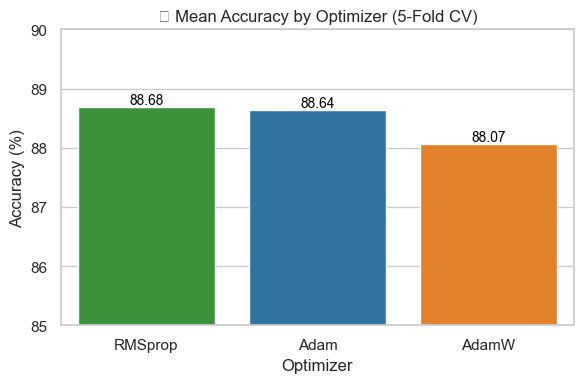

C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cv_df.sort_values("Mean Loss"),
C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:32: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Owner\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


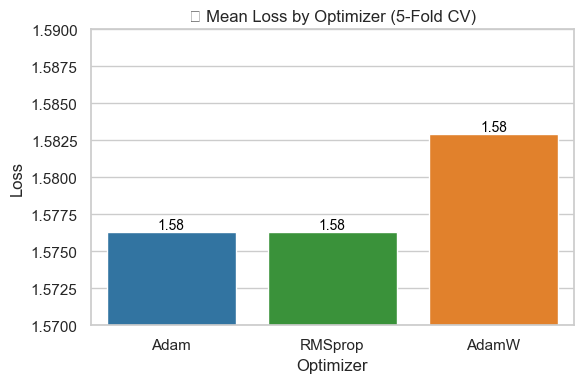

C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cv_df.sort_values("Mean Time (s)"),
C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:43: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_27200\3021272103.py:43: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Owner\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_

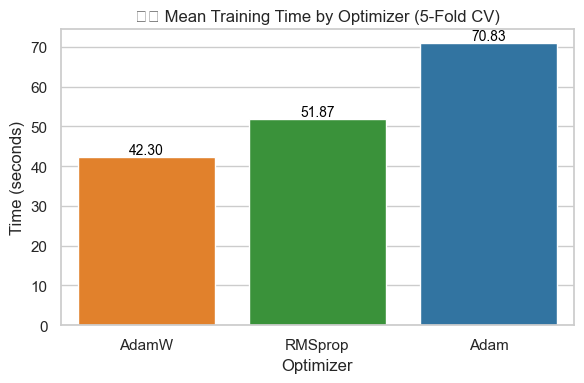

In [19]:
# Consistent color palette
colors = {"Adam": "#1f77b4", "RMSprop": "#2ca02c", "AdamW": "#ff7f0e"}

def add_value_labels(ax):
    """Add value labels on top of bars."""
    for p in ax.patches:
        val = f"{p.get_height():.2f}"
        ax.annotate(val, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

# Accuracy
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=cv_df.sort_values("Mean Accuracy (%)", ascending=False), 
                 x="Optimizer", y="Mean Accuracy (%)", palette=colors)
add_value_labels(ax)
plt.title("🔍 Mean Accuracy by Optimizer (5-Fold CV)")
plt.ylim(85, 90)
plt.ylabel("Accuracy (%)")
plt.xlabel("Optimizer")
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=cv_df.sort_values("Mean Loss"), 
                 x="Optimizer", y="Mean Loss", palette=colors)
add_value_labels(ax)
plt.title("📉 Mean Loss by Optimizer (5-Fold CV)")
plt.ylim(1.57, 1.59)
plt.ylabel("Loss")
plt.xlabel("Optimizer")
plt.tight_layout()
plt.show()

# Training Time
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=cv_df.sort_values("Mean Time (s)"), 
                 x="Optimizer", y="Mean Time (s)", palette=colors)
add_value_labels(ax)
plt.title("⏱️ Mean Training Time by Optimizer (5-Fold CV)")
plt.ylabel("Time (seconds)")
plt.xlabel("Optimizer")
plt.tight_layout()
plt.show()


### Interpretation of Optimizer Comparison Graphs

We visualize and interpret the results of our 5-fold cross-validation using bar plots:



###  1. Mean Accuracy by Optimizer

- All three optimizers performed similarly, with **RMSprop** achieving the highest mean accuracy (~88.68%).
- **Adam** and **AdamW** were close behind, suggesting that optimizer choice may not drastically affect accuracy with this architecture.
- However, RMSprop shows slightly more consistent generalization across folds.



### 2. Mean Loss by Optimizer

- All optimizers had nearly identical mean loss values (~1.576), confirming that they converge similarly on this dataset.
- The differences are minimal, further supporting the idea that the optimizers are functionally close in performance for KMNIST classification using a feedforward network.



###  3. Mean Training Time by Optimizer

- **AdamW** was the fastest to train, taking ~42 seconds per fold.
- **RMSprop** followed with ~52 seconds, while **Adam** was the slowest (~71 seconds).
- This is an important factor if training time is a concern, especially for larger datasets or deeper models.



###  Summary:

- **Best overall performer**: **RMSprop**, due to the best balance of accuracy and loss.
- **Best for speed**: **AdamW**, with lowest training time.
- While all optimizers achieved similar loss and accuracy, RMSprop had a slight edge in generalization, making it the **recommended choice for KMNIST** in this setup.
---


In [18]:
# Step 9b Export Results to CSV

cv_df.to_csv("cv_results_summary.csv", index=False)
tuned_df.to_csv("tuned_results_summary.csv", index=False)
print("CSV files saved: cv_results_summary.csv, tuned_results_summary.csv")


CSV files saved: cv_results_summary.csv, tuned_results_summary.csv
